In [1]:
import os
import glob
import numpy as np
import mdtraj as md
import barnaba as bb
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
import pyemma.plots as mplt
import nglview as ngv


refdir = "../../REST2_dynamics/UUCG/300K/reference_structures"
outdir = "../output/UUCG/300K/other_CV_maps"
os.system("mkdir %s" % outdir)

reference = "%s/UUCG-native.pdb"%refdir  #usually is the native structure.
topol = "%s/UUCG-native.pdb"%refdir  #doesn't have to be the same as reference.
traj = "../output/UUCG/300K/traj_all_ffs-rna-center.xtc" #needs to have the same number of atoms as the reference pdb.
nmr = "%s/2KOC.pdb"%refdir #directory of NMR models


mkdir: cannot create directory ‘../output/UUCG/300K/other_CV_maps’: File exists


# Custom functions

In [2]:
#function to calculate eRMSD.
def ermsd_cluster(gvecs, centroids, labels):
    '''
    Calculate intra-cluster eRMSD. 
        gvecs: input features for eRMSD.
        centroids: array of cluster centroid G-vecs. 
        labels: array of cluster indexes. 
    '''
    ermsd = []
    #calculate the number of nucleotides from G-vecs shape
    N = (gvecs.shape[-1]/4)**0.5
    #calculate ermsd (based on Euclidean distance between Gvecs) for members of each cluster.
    for i in range(len(centroids)):
        idx=np.where(labels==i)[0]
        ermsd_i = [(1/N * np.sum((centroids[i]-gvecs[x])**2)**0.5 )**0.5 for x in idx]
        ermsd.append(ermsd_i)
    
    ermsd = np.asarray(ermsd, dtype='object')
    return ermsd


In [3]:
#Function to calculate cluster centroids.
def dbscan_centers(gvecs, labels, unique_labels):
    '''
    Find centroids of DBSCAN clusters.
    --gvecs: array of G-vectors (shape num_frames,4*num_nts*num_nts)
    --labels: DBSCAN-derived cluster label ids.
    --unique_labels: set of unique labels (contains noise).
    '''
    cent_idxs=[] #list to store the centroid indexes.
    
    N=(gvecs.shape[-1]/4)**0.5 #find num_nts.
    
    for i in range(len(unique_labels)-1): #exclude noise label which is at the end of the set.
        print("Finding centroid for cluster...%d"%i)
        idx = np.where(labels==i)[0]
        gvecs_temp = gvecs[idx]
        dists = squareform(pdist(gvecs_temp))/(float(N)**0.5) #calculate (all-to-all) eRMSD matrix.
        dd = np.sum(dists,axis=1) #sum eRMSDs for each cluster member.
        min_idx = np.argmin(dd) #centroid is the member that has minimum sum of eRMSDs.
        cent_idxs.append(idx[min_idx]) #get the cluster centroid index.
        
    return cent_idxs

In [4]:
#Function to create a custom cmap based on tab20 to be used throughout.
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

In [5]:
def density_estimation(m1, m2):
    xmin = np.min(m1)
    xmax = np.max(m1)
    ymin = np.min(m2)
    ymax = np.max(m2)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z , xmin, xmax, ymin, ymax

# Calculate the CVs

In [6]:
#Load the trajectory.
t = md.load(traj, top=reference)
nat = md.load(reference)
NMR = md.load(nmr)

print(t)

<mdtraj.Trajectory with 80008 frames, 447 atoms, 14 residues, and unitcells>


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:202: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


In [7]:
#Find atom indexes to measure angles and distances.
U_L1_N1 = [atom.index for atom in t.topology.atoms if atom.name=="N1" and atom.residue.index==5]
U_L1_O2 = [atom.index for atom in t.topology.atoms if atom.name=="O2" and atom.residue.index==5]
C_L3_N1 = [atom.index for atom in t.topology.atoms if atom.name=="N1" and atom.residue.index==7]
G_L4_N1 = [atom.index for atom in t.topology.atoms if atom.name=="N1" and atom.residue.index==8]
G_L4_N3 = [atom.index for atom in t.topology.atoms if atom.name=="N3" and atom.residue.index==8]

#NMR models have more atoms due to a 5' phosphate group.
U_L1_N1_nmr = [atom.index for atom in NMR.topology.atoms if atom.name=="N1" and atom.residue.index==5]
U_L1_O2_nmr = [atom.index for atom in NMR.topology.atoms if atom.name=="O2" and atom.residue.index==5]
C_L3_N1_nmr = [atom.index for atom in NMR.topology.atoms if atom.name=="N1" and atom.residue.index==7]
G_L4_N1_nmr = [atom.index for atom in NMR.topology.atoms if atom.name=="N1" and atom.residue.index==8]
G_L4_N3_nmr = [atom.index for atom in NMR.topology.atoms if atom.name=="N3" and atom.residue.index==8]

print(U_L1_N1, U_L1_O2, C_L3_N1, G_L4_N1, G_L4_N3)

[173] [183] [233] [271] [277]


In [8]:
#Calculate various angles and distances.

#Calculate G9-chi torsion.
G9_chi, res = bb.backbone_angles(traj, topology=reference, residues=["G_9_0"] , angles=["chi"])
G9_chi_nat, res = bb.backbone_angles(reference, residues=["G_9_0"] , angles=["chi"])
G9_chi_nmr, res = bb.backbone_angles(nmr, residues=["G_9_0"] , angles=["chi"])
print(G9_chi.shape)

#Calculate U6-C8 N1 distances.
L1_L3_dist = md.compute_distances(t, atom_pairs=[U_L1_N1+C_L3_N1])
L1_L3_dist_nat = md.compute_distances(nat, atom_pairs=[U_L1_N1+C_L3_N1])
L1_L3_dist_nmr = md.compute_distances(NMR, atom_pairs=[U_L1_N1_nmr+C_L3_N1_nmr])
print(L1_L3_dist.shape)

#Calculate U6-G9 N1-N1 distances. 
L1_L4_N11_dist = md.compute_distances(t, atom_pairs=[U_L1_N1+G_L4_N1])
L1_L4_N11_dist_nat = md.compute_distances(nat, atom_pairs=[U_L1_N1+G_L4_N1])
L1_L4_N11_dist_nmr = md.compute_distances(NMR, atom_pairs=[U_L1_N1_nmr+G_L4_N1_nmr])
print(L1_L4_N11_dist.shape)

#Calculate U6-G9 N1-N3 distances. 
L1_L4_N13_dist = md.compute_distances(t, atom_pairs=[U_L1_N1+G_L4_N3])
L1_L4_N13_dist_nat = md.compute_distances(nat, atom_pairs=[U_L1_N1+G_L4_N3])
L1_L4_N13_dist_nmr = md.compute_distances(NMR, atom_pairs=[U_L1_N1_nmr+G_L4_N3_nmr])
print(L1_L4_N13_dist.shape)

#Calculate U6-G9 O2-N1 distances. 
L1_L4_O2N1_dist = md.compute_distances(t, atom_pairs=[U_L1_O2+G_L4_N1])
L1_L4_O2N1_dist_nat = md.compute_distances(nat, atom_pairs=[U_L1_O2+G_L4_N1])
L1_L4_O2N1_dist_nmr = md.compute_distances(NMR, atom_pairs=[U_L1_O2_nmr+G_L4_N1_nmr])
print(L1_L4_O2N1_dist.shape)

# Loading ../output/UUCG/300K/traj_all_ffs-rna-center.xtc 
# Loading ../REST2_dynamics/UUCG/300K/reference_structures/UUCG-native.pdb 


(80008, 1, 1)
(80008, 1)
(80008, 1)
(80008, 1)
(80008, 1)


# Loading ../REST2_dynamics/UUCG/300K/reference_structures/2KOC.pdb 


## Internucleotide distances

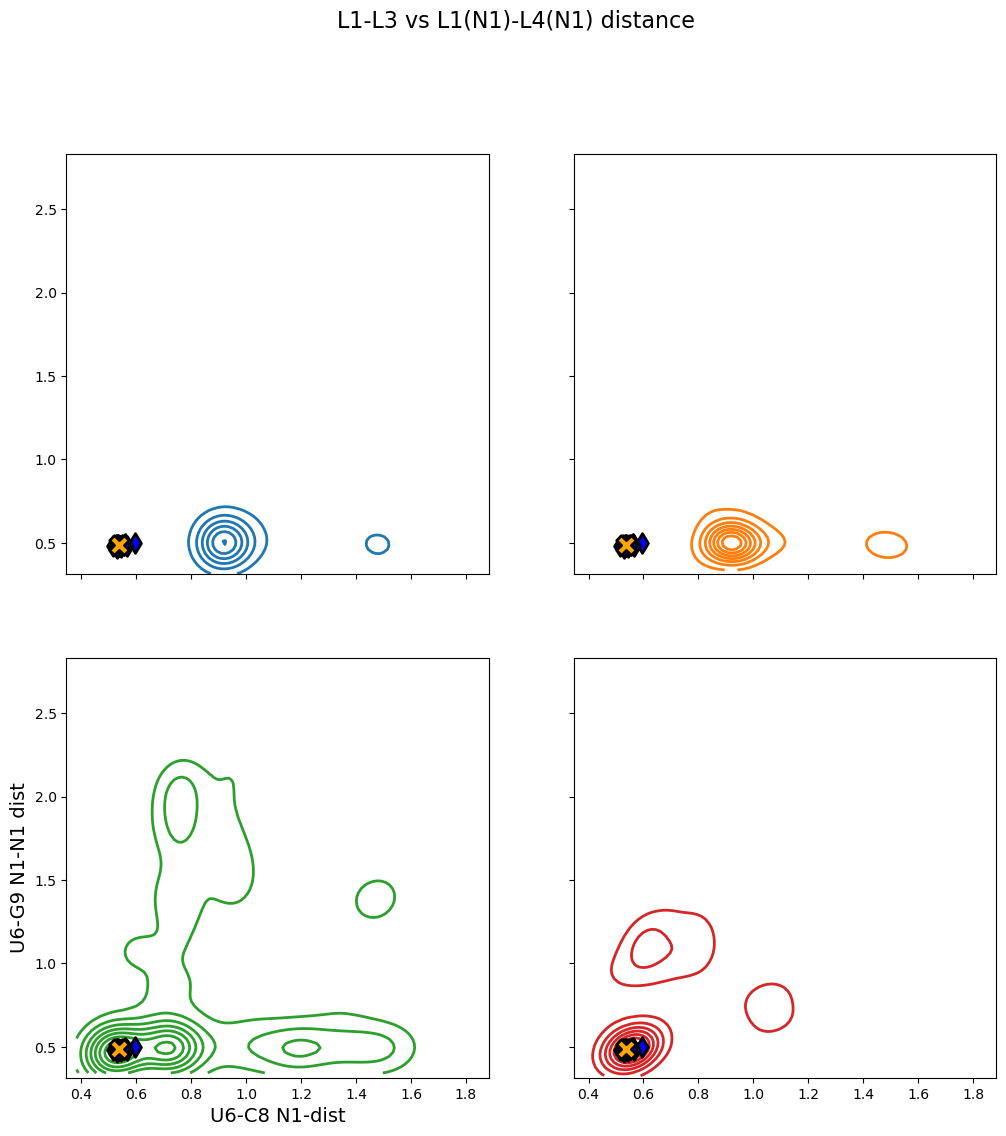

In [9]:
#Plot U7-C8 N1 distance vs. G9 OP1-N2 distance.

# define some basic stuff for data.
rows=2
cols=2

dims = [0, 1]

ffs = ["amber14SB", "amber14SB_{CP}", "Chen-Garcia", "DESRES"]
runs = ["ff14", "ff14_CP", "CG", "desres"]

fr_per_trj=len(t)//(len(runs))

#define figure and set aspect.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))

#calculate explained variance for the first two components.

#define colors for clusters. Noise is gray points.
cat_cmap = categorical_cmap(len(ffs), 1, "tab10")


#scatterplot the noise
# plt.scatter(w[:,0],w[:,1], s=size, c=clust_colors, zorder=0)

#plot the contours.
for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)
    
    plt.xlim([L1_L3_dist[:,0].min(), L1_L3_dist[:,0].max()])
    plt.ylim([L1_L4_N11_dist[:,0].min(), L1_L4_N11_dist[:,0].max()])

    x = L1_L3_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    y = L1_L4_N11_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 8, colors=cat_cmap([i]), extend=max, linewidths=2)
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    #Plot near-native point (the first one since (if) trajectory starts from native state.)
    plt.scatter(L1_L3_dist_nat[:,0], L1_L4_N11_dist_nat[:,0], s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L3_dist_nmr[:,0], L1_L4_N11_dist_nmr[:,0], s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble


#set nice limits
ax[1,0].set_xlabel("U6-C8 N1-dist", fontsize=14)
ax[1,0].set_ylabel("U6-G9 N1-N1 dist", fontsize=14)
# plt.legend(bbox_to_anchor=(1.2, 1), labelspacing=0.8, borderpad=1.2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
plt.suptitle("L1-L3 vs L1(N1)-L4(N1) distance", fontsize=16, y=1.)
plt.savefig("%s/L1_L3_distance_vs_L1_L4_N1_N1_distance-contour_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')

plt.show()

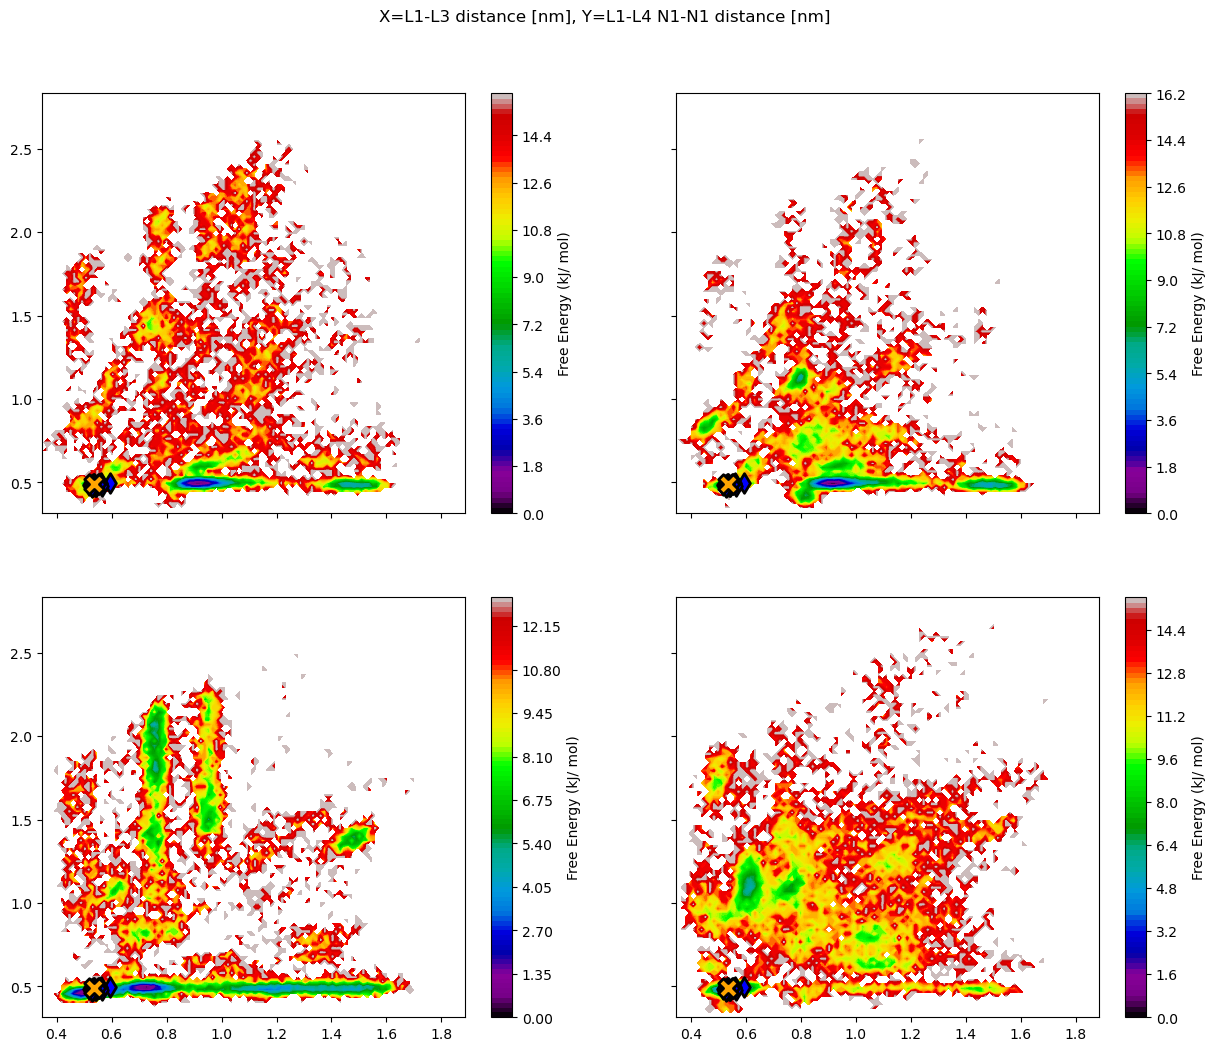

In [10]:
def plot_FES_and_dash_clusts(x_feat_traj, y_feat_traj, x_label, y_label, title):
    """Input: A PC featurised pyemma trajectory (shape = [frames, dimensions]), the PC featurised clusters,
              a dimension list with the 2 dimensions for the FES, x_label string, y_label string, title string.
       Output: Shows a free energy surface wrt the 2 dimensions, showing cluster centres if 
               specified."""
    mplt.plot_free_energy(x_feat_traj, y_feat_traj, kT=2.494, cbar_label="Free Energy (kJ/ mol)"); # plot FES wrt the PC dimensions given in dims
    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)

    # Plot the native (reference) and seed structures on PC space.
    plt.scatter(L2_L3_dist_nat[:,0], L4_dist_nat[:,0], s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L2_L3_dist_nmr[:,0], L4_dist_nmr[:,0], s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble

    plt.title(title, fontsize=20, pad=15)

    
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(15, 12))


for i, run in enumerate(runs):
    ax = plt.subplot(rows, cols, i+1)
            
    x = L1_L3_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    y = L1_L4_N11_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    
    mplt.plot_free_energy(xall=x, yall=y, ax=ax, kT=2.494, cbar_label="Free Energy (kJ/ mol)")

    plt.scatter(L1_L3_dist_nat[:,0], L1_L4_N11_dist_nat[:,0], s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L3_dist_nmr[:,0], L1_L4_N11_dist_nmr[:,0], s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble
    
    plt.xlim([L1_L3_dist[:,0].min(), L1_L3_dist[:,0].max()])
    plt.ylim([L1_L4_N11_dist[:,0].min(), L1_L4_N11_dist[:,0].max()])  
    
plt.suptitle("X=L1-L3 distance [nm], Y=L1-L4 N1-N1 distance [nm]", y=0.95)
plt.savefig("%s/L1_L3_distance_vs_L1_L4_N1_N1_distance-FES_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()

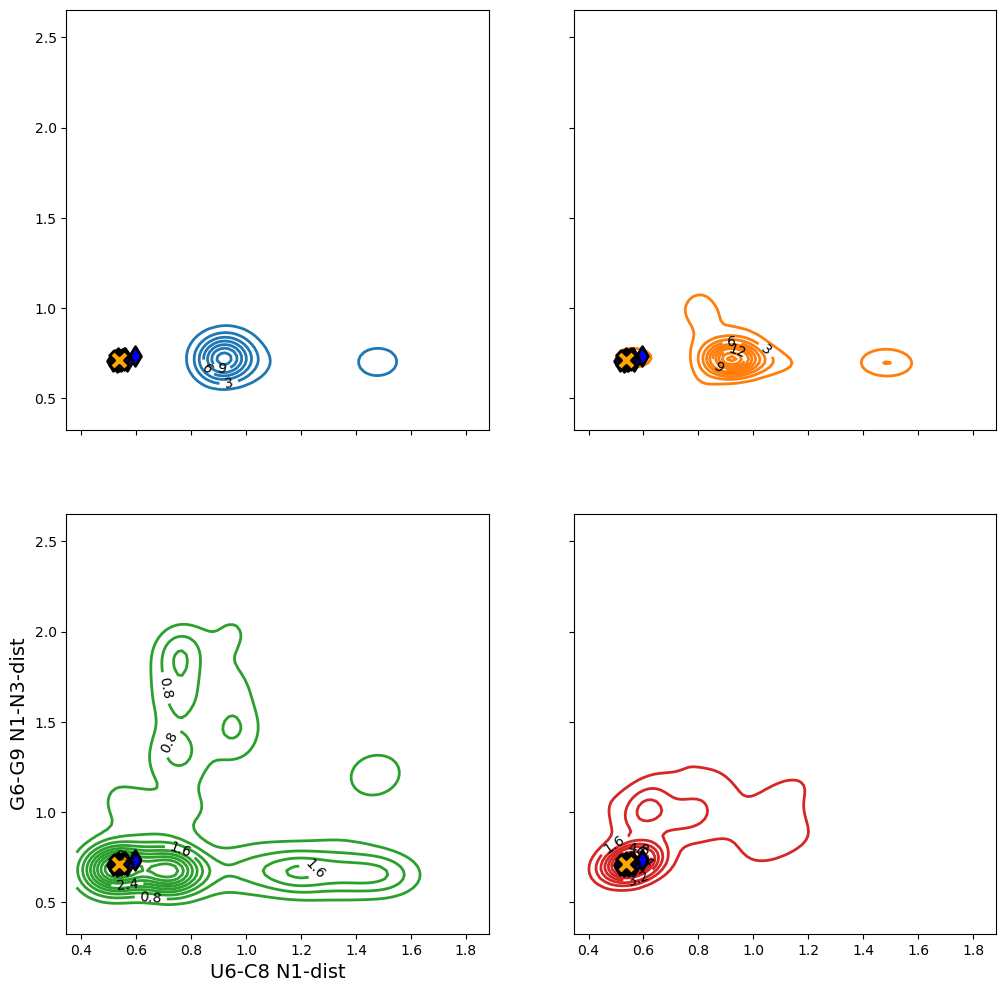

In [11]:
# define some basic stuff for data.

rows=2
cols=2

dims = [0, 1]

#define figure and set aspect.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))
# ax.set_aspect(1)

#plot the contours.

for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)
    
    plt.xlim([L1_L3_dist[:,0].min(), L1_L3_dist[:,0].max()])
    plt.ylim([L1_L4_N13_dist.min(), L1_L4_N13_dist.max()])


    x = L1_L3_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    y = L1_L4_N13_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 10, colors=cat_cmap([i]), extend=max, linewidths=2)
    plt.clabel(CS, levels=CS.levels[::2], inline=1, fontsize=10, colors="k")
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    #Plot near-native point (the first one since (if) trajectory starts from native state.)
    plt.scatter(L1_L3_dist_nat[:,0], L1_L4_N13_dist_nat, s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L3_dist_nmr[:,0], L1_L4_N13_dist_nmr, s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble

#set nice limits
ax[1,0].set_xlabel("U6-C8 N1-dist", fontsize=14)
ax[1,0].set_ylabel("G6-G9 N1-N3-dist", fontsize=14)

plt.savefig("%s/L1_L3_distance_vs_L1_L4_N1_N3-contour_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()

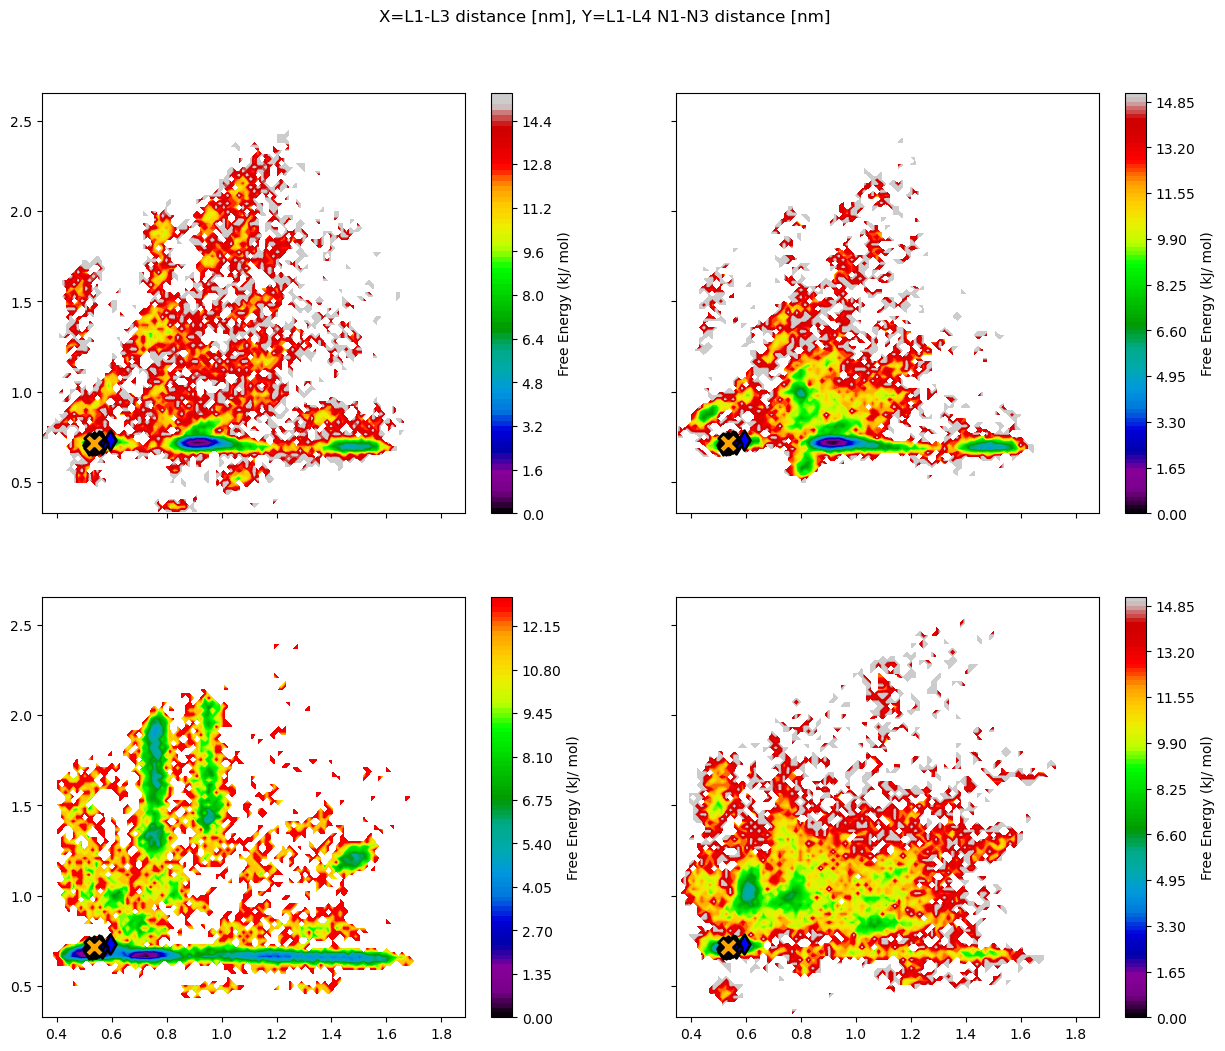

In [12]:
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(15, 12))


for i, run in enumerate(runs):
    ax = plt.subplot(rows, cols, i+1)
            
    x = L1_L3_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    y = L1_L4_N13_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]
    
    mplt.plot_free_energy(xall=x, yall=y, ax=ax, kT=2.494, cbar_label="Free Energy (kJ/ mol)", vmin=0, vmax=15)

    plt.scatter(L1_L3_dist_nat[:,0], L1_L4_N13_dist_nat, s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L3_dist_nmr[:,0], L1_L4_N13_dist_nmr, s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble
    
    plt.xlim([L1_L3_dist[:,0].min(), L1_L3_dist[:,0].max()])
    plt.ylim([L1_L4_N13_dist[:,0].min(), L1_L4_N13_dist[:,0].max()])  
    

plt.suptitle("X=L1-L3 distance [nm], Y=L1-L4 N1-N3 distance [nm]", y=0.95)

plt.savefig("%s/L1_L3_distance_vs_L1_L4_N1_N3-FES_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')

plt.show()

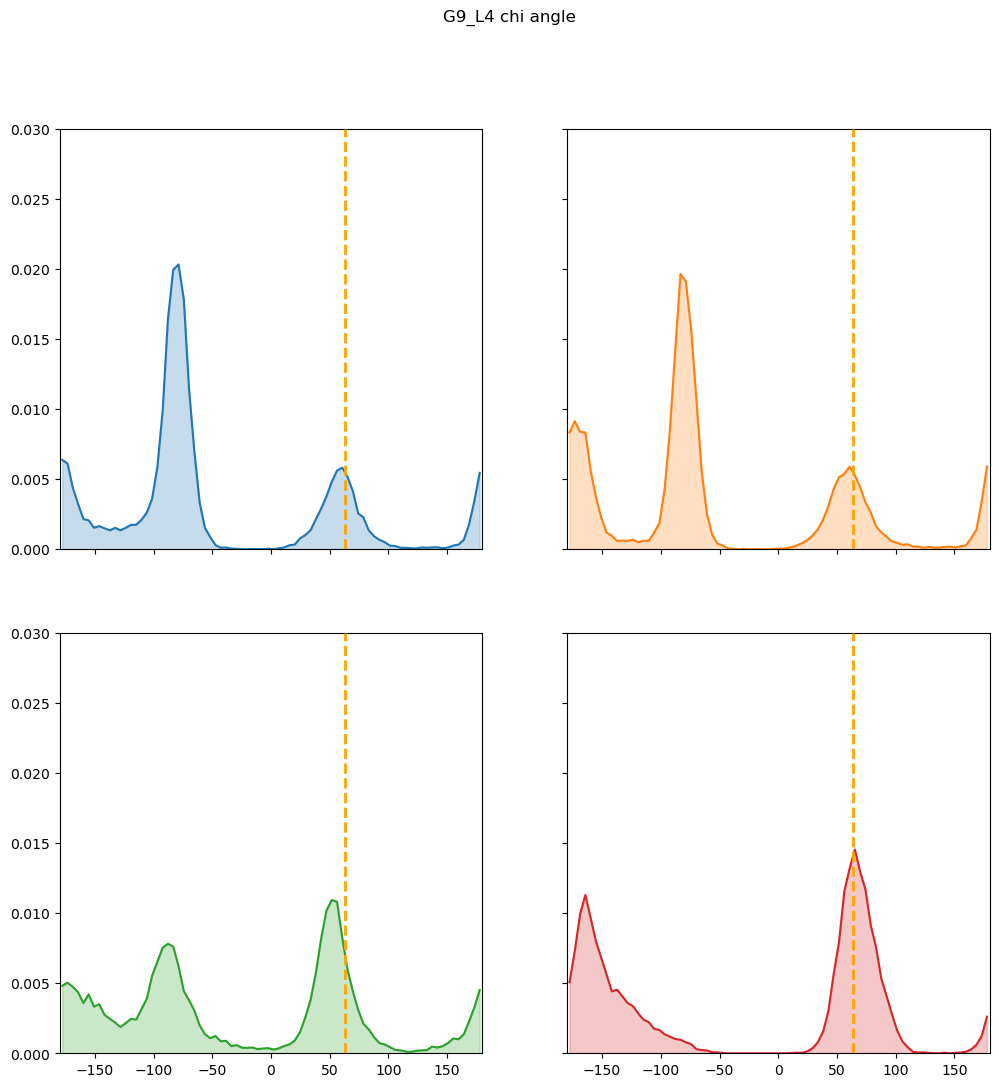

In [13]:
#Plot histograms.

# define some basic stuff for data.
rows=2
cols=2

#define figure and set aspect.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))
# ax.set_aspect(1)

#plot the contours.
bins=80
for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)
    
    plt.xlim([-180, 180])
    plt.ylim([0, 0.03])


    x = G9_chi[i*fr_per_trj:(i+1)*fr_per_trj, 0]*180/np.pi
    hh, ee = np.histogram(x,bins=bins,density=True)

    plt.plot(0.5*(ee[1:]+ee[:-1]),hh, color=cat_cmap(i))
    plt.fill_between(0.5*(ee[1:]+ee[:-1]),hh, alpha=0.25, color=cat_cmap(i))


    #Plot near-native point (the first one since (if) trajectory starts from native state.)
    plt.axvline(G9_chi_nat[:,0]*(180/np.pi), ls="--", lw=2, c="orange", zorder=3, label="Native") #plot native

plt.suptitle("G9_L4 chi angle")

plt.savefig("%s/L4_chi-contour_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')

plt.show()

## U1-G9 dist. vs G9 χ-angle

In [14]:
G9_chi_deg = np.asarray([(2*np.pi+a)*180/np.pi if a<0 else a*180/np.pi for a in G9_chi]).flatten()
G9_chi_deg_nat = np.asarray([(2*np.pi+a)*180/np.pi if a<0 else a*180/np.pi for a in G9_chi_nat]).flatten()
G9_chi_deg_nmr = np.asarray([(2*np.pi+a)*180/np.pi if a<0 else a*180/np.pi for a in G9_chi_nmr]).flatten()

print(G9_chi_deg.shape, G9_chi_deg_nat.shape, G9_chi_deg_nmr.shape)

(80008,) (1,) (20,)


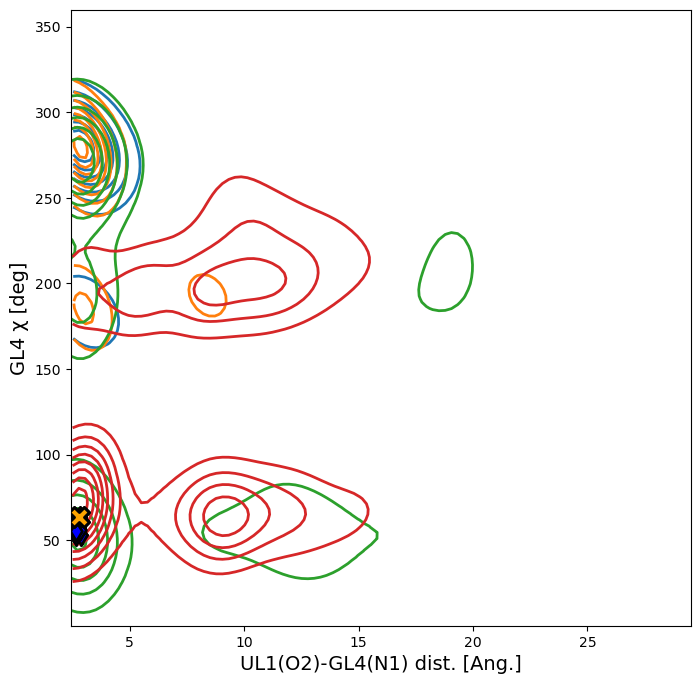

In [15]:
# define some basic stuff for data.

rows=1
cols=1

#define figure and set aspect.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(8, 8))
# ax.set_aspect(1)

#plot the contours.
plt.subplot(rows, cols, 1)


for i, run in enumerate(runs):
    
    plt.xlim([L1_L4_O2N1_dist[:,0].min()*10, L1_L4_O2N1_dist[:,0].max()*10])
    plt.ylim([G9_chi_deg.min(), G9_chi_deg.max()])

    x = L1_L4_O2N1_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]*10
    y = G9_chi_deg[i*fr_per_trj:(i+1)*fr_per_trj]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 8, colors=cat_cmap([i]), extend=max, linewidths=2)
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    #Plot near-native point (the first one since (if) trajectory starts from native state.)
    plt.scatter(L1_L4_O2N1_dist_nat[:,0]*10, G9_chi_deg_nat, s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L4_O2N1_dist_nmr[:,0]*10, G9_chi_deg_nmr, s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble

#set nice limits
plt.xlabel("UL1(O2)-GL4(N1) dist. [Ang.]", fontsize=14)
plt.ylabel("GL4 χ [deg]", fontsize=14)

plt.savefig("%s/L1_L4_O2N1_distance_vs_L4_chi-contour.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()

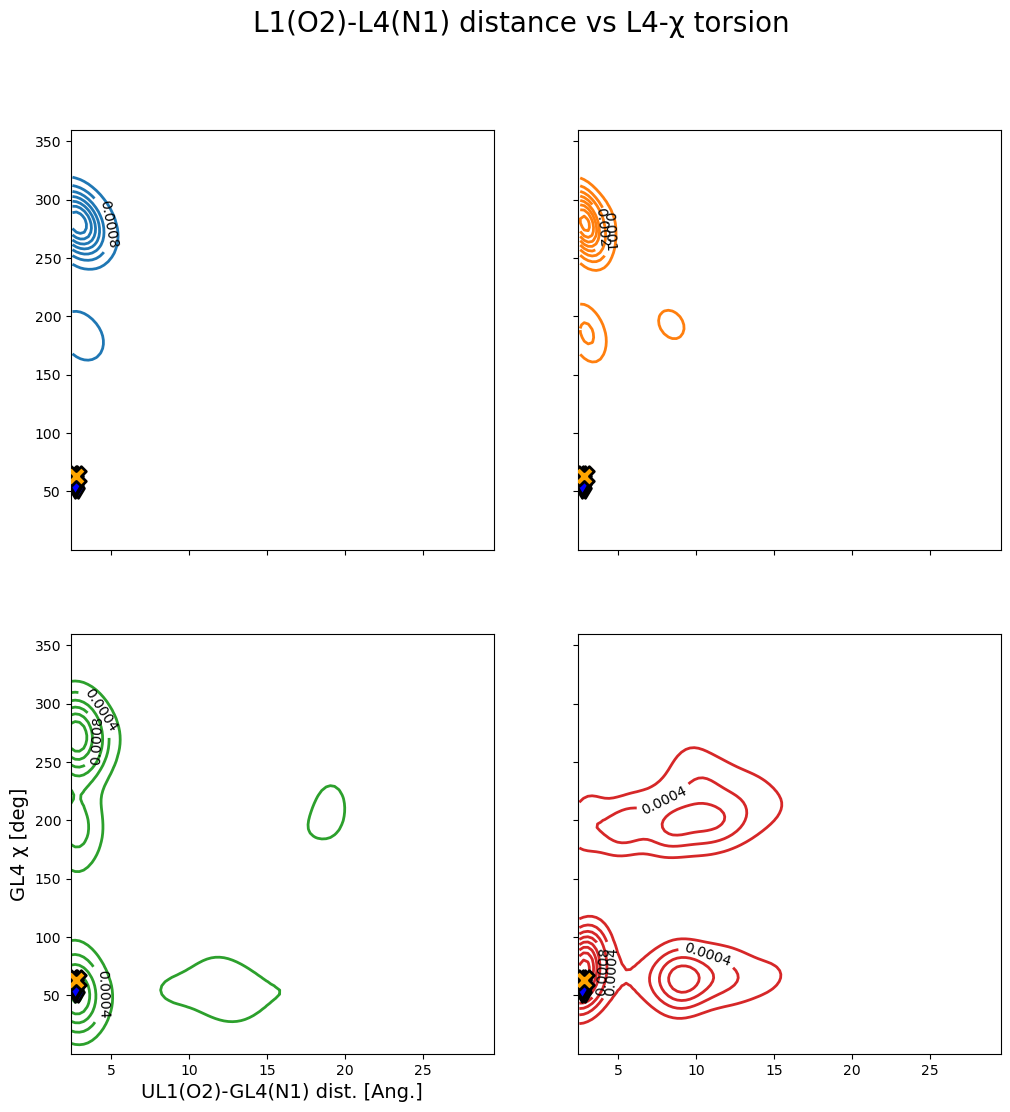

In [16]:
# define some basic stuff for data.

rows=2
cols=2

dims = [0, 1]

#define figure and set aspect.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 12))
# ax.set_aspect(1)

#plot the contours.
for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)
    
    plt.xlim([L1_L4_O2N1_dist[:,0].min()*10, L1_L4_O2N1_dist[:,0].max()*10])
    plt.ylim([G9_chi_deg.min(), G9_chi_deg.max()])

    x = L1_L4_O2N1_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]*10
    y = G9_chi_deg[i*fr_per_trj:(i+1)*fr_per_trj]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 8, colors=cat_cmap([i]), extend=max, linewidths=2)
    plt.clabel(CS, levels=CS.levels[::2], inline=1, fontsize=10, colors="k")
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    #Plot near-native point (the first one since (if) trajectory starts from native state.)
    plt.scatter(L1_L4_O2N1_dist_nat[:,0]*10, G9_chi_deg_nat, s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L4_O2N1_dist_nmr[:,0]*10, G9_chi_deg_nmr, s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble

#set nice limits
ax[1,0].set_xlabel("UL1(O2)-GL4(N1) dist. [Ang.]", fontsize=14)
ax[1,0].set_ylabel("GL4 χ [deg]", fontsize=14)
plt.suptitle("L1(O2)-L4(N1) distance vs L4-χ torsion", fontsize=20)
plt.savefig("%s/L1_L4_O2N1_distance_vs_L4_chi-contour_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()

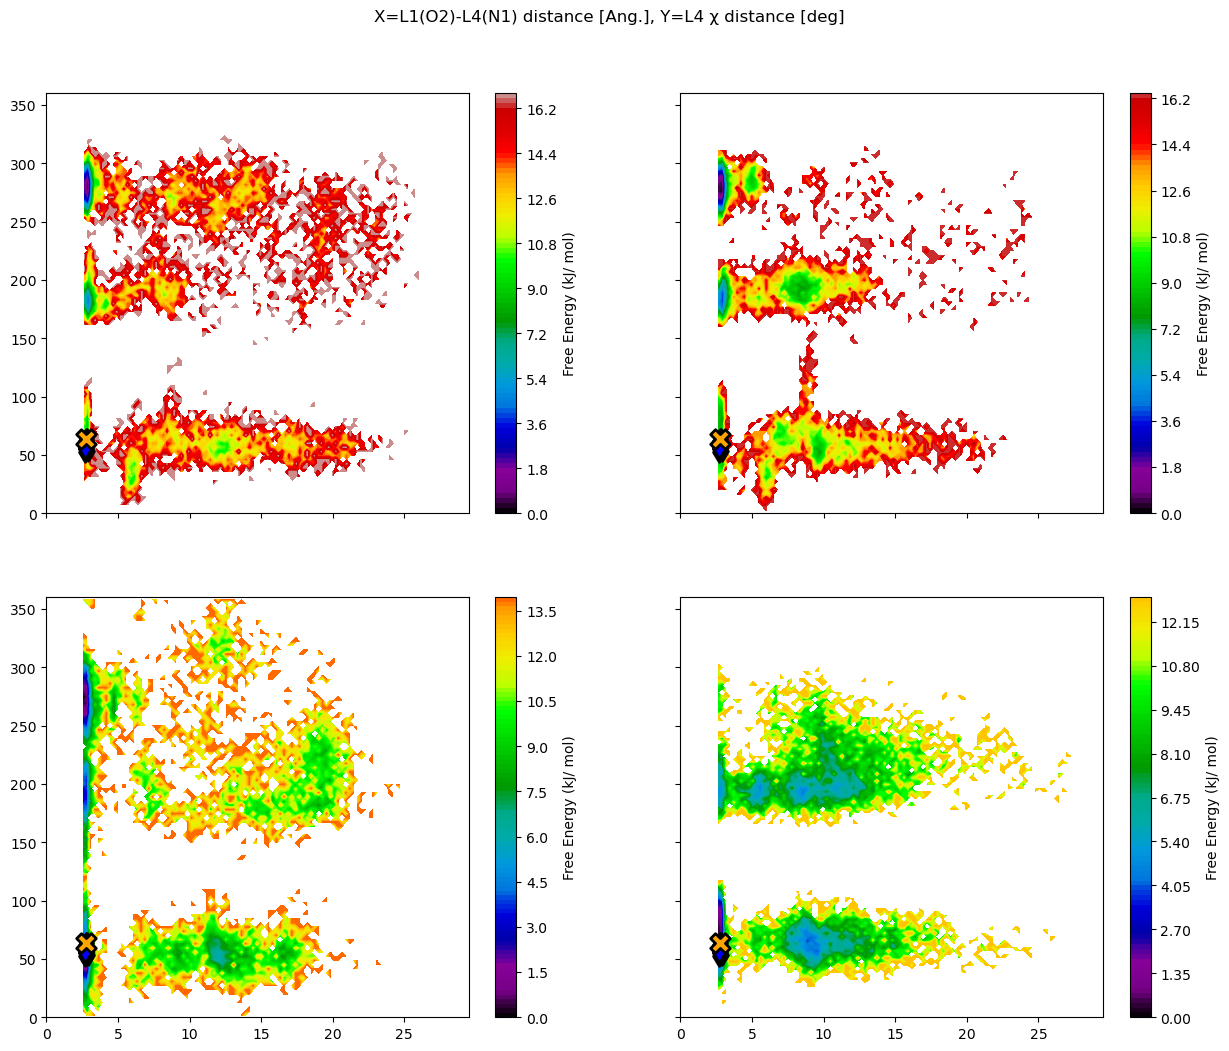

In [17]:
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(15, 12))

for i, run in enumerate(runs):
    ax = plt.subplot(rows, cols, i+1)
            
    x = L1_L4_O2N1_dist[i*fr_per_trj:(i+1)*fr_per_trj, 0]*10
    y = G9_chi_deg[i*fr_per_trj:(i+1)*fr_per_trj]
    
    mplt.plot_free_energy(xall=x, yall=y, ax=ax, kT=2.494, cbar_label="Free Energy (kJ/ mol)", vmin=0, vmax=17)

    plt.scatter(L1_L4_O2N1_dist_nat[:,0]*10, G9_chi_deg_nat, s=200, lw=2, c="orange", ec="black", zorder=3, marker="X", label="Native") #plot native
    plt.scatter(L1_L4_O2N1_dist_nmr[:,0]*10, G9_chi_deg_nmr, s=100, lw=2, c="blue", ec="black", zorder=2, marker="d", label="NMR") #plot NMR ensemble
    
    plt.xlim([0, L1_L4_O2N1_dist[:,0].max()*10])
    plt.ylim([0, 360])   

plt.suptitle("X=L1(O2)-L4(N1) distance [Ang.], Y=L4 χ distance [deg]", y=0.95)
plt.savefig("%s/L1_L4_O2N1_distance_vs_L4_chi-FES_panels.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()

## Base-phosphate H-bonds (single FF trajectory)

In [18]:
#make atom index input (here just for G9; more residues can be added using the same recipe)
#you need to do this only once
os.system('echo "1 & a OP*\n" "1 & a N2 | a H21 | a H22 & r 9\n" "name 2 OP\n" "name 3 G9_NH2\n" "del 0\n" "del 0\n" "q\n" | gmx make_ndx -f %s/UUCG-native.pdb -o %s/OP.ndx'
          %(refdir, outdir))

Going to read 0 old index file(s)
Analysing residue names:
There are:    14        RNA residues

  0 System              :   447 atoms
  1 RNA                 :   447 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Copied index group 1 'RNA'
Found 26 atoms with name OP*
Merged two groups with AND: 447 26 -> 26

  2 RNA_&_OP*           :    26 atoms

> 
Copied index group 1 'RNA'
Found 5 atoms with name N2
Merged two groups with AND: 447 5 -> 5
Found 5 atoms with name H21
Merged two groups with OR: 5 5 -> 10
Found 5 atoms with name H22
Merged two groups with OR: 10 5 -> 15
Merged two groups with AND: 15 34 -> 3

  3 RNA_&_N2_H21_H22_&_r_9:     3

                     :-) GROMACS - gmx make_ndx, 2018.8 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

0

In [19]:
# calculate base-phosphate H-bonds for loop purines
ffs = ["amber14SB", "amber14SB_{CP}", "Chen-Garcia", "DESRES"]
runs = ["ff14", "ff14_CP", "CG", "desres"]

for run in runs:
    os.system('echo "1\n" "0\n" "q\n"| gmx hbond -f %s/../traj_%s-rna.xtc -s %s/../input_files/ff14SB/nmr-seeded/topol0.tpr \
-n %s/OP.ndx -num %s/G9_OP-hbnum-%s.xvg'%(outdir, run, refdir, outdir, outdir, run))

                      :-) GROMACS - gmx hbond, 2018.8 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Specify 2 groups to analyze:
Selected 1: 'G9_NH2'
Selected 0: 'OP'
Checking for overlap in atoms between G9_NH2 and OP
Calculating hydrogen bonds between G9_NH2 (3 atoms) and OP (26 atoms)
Found 1 donors and 27 acceptors

Will do grid-seach on 14x14x14 grid, rcut=0.35
Frame loop parallelized with OpenMP using 4 threads.


Reading file ../REST2_dynamics/UUCG/300K/reference_structures/../input_files/ff14SB/nmr-seeded/topol0.tpr, VERSION 2018.8 (single precision)
Group     0 (             OP) has    26 elements
Group     1 (         G9_NH2) has     3 elements
Reading frame  100000 time 1999960.000   

GROMACS reminds you: "What's Your Definition Of Dirty ?" (G. Michael)

                      :-) GROMACS - gmx hbond, 2018.8 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvet

limit_output extension: Maximum message size of 10000 exceeded with 11025 characters

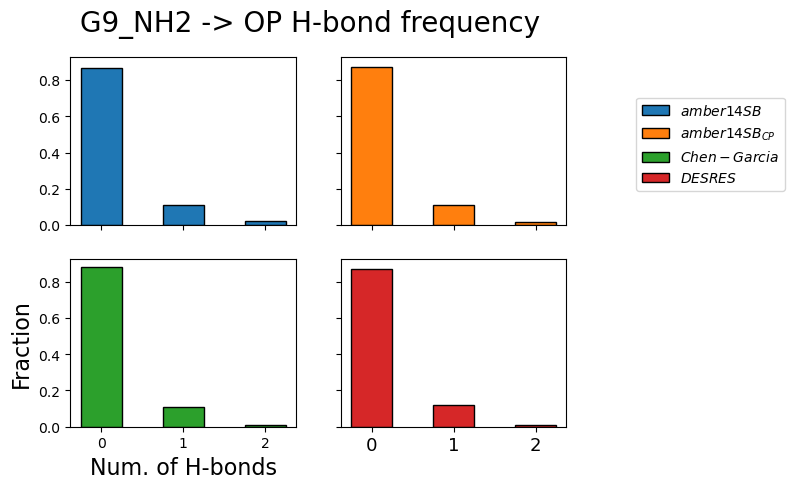

In [20]:
#plot the H-bond data for G9_NH2->OP bonds.
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
legend_handles=[]
for r, run in enumerate(runs):
    
    G9 = np.loadtxt("%s/G9_OP-hbnum-%s.xvg"%(outdir, run), comments=["@","#"])
    G9_sum=G9[:,1]+G9[:,2]

    bins = np.arange(0, G9_sum.max()+0.5) - 0.5

    hist = axs[r//2, r%2].hist(G9_sum, bins=bins, align='mid', density=True, rwidth=0.5, color=colors[r], ec="black", label=ffs[r:r+1])
    
handles = [matplotlib.patches.Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
plt.legend(handles, [r'$%s$'%f for f in ffs], bbox_to_anchor=(2, 2))

axs[1,0].set_xlabel("Num. of H-bonds", fontsize=16)
axs[1,0].set_ylabel("Fraction", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.suptitle("G9_NH2 -> OP H-bond frequency", fontsize=20)

plt.savefig("%s/Hbond_frequencies.png"%outdir, dpi=600, format="png", bbox_inches='tight')
plt.show()